# Equilibrating simulations

In this tutorial we will explain what equilibration of a simulation is and how MDMC
can ensure enough equilibration has been done before running the simulation.

## What is equilibration?
Equilibration of a simulation involves running the simulation for a short period
of time to make it ready for a 'production run' (i.e. one in which we record trajectories).

When the simulation is first set up, it has usually been configured in a certain way
such as having atoms spaced in a grid at certain densities. We don't want this to affect
our trajectories, and we also want properties like kinetic and potential energies to be
distributed around the simulation so that it better reflects the 'real-life' behaviour
of molecules.

First, let us create and minimize an MDMC `Simulation`. Minimization, like equilibration, 
is a short run of the MD simulation which resolves issues like atoms overlapping
(which would affect energy readings for the simulation).

In [1]:
from MDMC.MD import Universe, Simulation, Atom, Dispersion, LennardJones

# create the topology
universe = Universe(dimensions=23.0668)
Ar = Atom('Ar', charge=0., mass=36.0)
universe.fill(Ar, num_density=0.0176)

# define intermolecular forces
Ar_dispersion = Dispersion(universe,
                           (Ar.atom_type, Ar.atom_type),
                           cutoff=8.,
                           function=LennardJones(epsilon=1.0243, sigma=3.36))

# MD Engine setup
simulation = Simulation(universe,
                        engine="lammps",
                        time_step=10.18893,
                        temperature=120.,
                        traj_step=15)

simulation.minimize(n_steps=50)

Universe created with:
Dimensions [23.07 23.07 23.07]


LAMMPS (2 Aug 2023 - Update 4)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
LAMMPS output is captured by PyLammps wrapper


LAMMPS (2 Aug 2023 - Update 4)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
LAMMPS output is captured by PyLammps wrapper
Total wall time: 0:00:00


Simulation created with lammps engine and settings:
temperature: 120.0 K 




We can then equilibrate the simulation. This is done by calling `simulation.run` with `equilibration=True`.
Normally, to run for, say, 5000 steps, call `simulation.run(n_steps=5000, equilibration=True)`, but here
we will put it in a `for` loop that will record how the temperature and potential energy of the simulation
changes over time and run the equilibration in smaller chunks.

Note that `engine.eval()` evaluates variables in the simulation's MD engine; `temp` and `pe` are
the LAMMPS names for temperature and potential energy. It may vary in other MD engines.

In [2]:
temperatures = []
potentials = []

for _ in range(500):
    simulation.run(n_steps=10, equilibration=True)
    temperatures.append(simulation.engine.eval('temp'))
    potentials.append(simulation.engine.eval('pe'))

This can then be plotted as graphs of how these properties change over time
with matplotlib. We create a plot function so we can use it later.

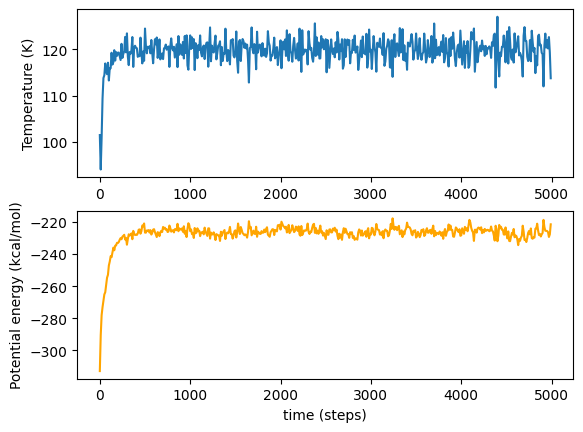

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_vars(temperatures, potentials, line=0):
    plt.figure()
    plt.subplot(211)
    plt.plot(np.arange(len(temperatures))*10, temperatures)
    plt.ylabel('Temperature (K)')
    if line:
        plt.axvline(x=line, linestyle='--', color='lime')

    plt.subplot(212)
    plt.plot(np.arange(len(potentials))*10, potentials, color="orange")
    plt.xlabel('time (steps)')
    plt.ylabel('Potential energy (kcal/mol)')
    if line:
        plt.axvline(x=line, linestyle='--', color='lime')

    plt.show()

plot_vars(temperatures, potentials)

We can see that at first there is a lot of change, and around 2000 steps both quantities cease to 
increase or decrease in any meaningful way; there is, of course, slight oscillation and uncertainty
in the readings (which is unavoidable in molecular dynamics simulation), but ultimately it is
stationary. Once this stationary behaviour has been reached, we would consider the simulation
to have equilibrated successfully.

## Avoiding under- or over- equilibrating

Indeed, the next question would be 'how much equilibration is necessary?'. If we under-equilibrate,
then it will affect our observed trajectory when we run the simulation. If we over-equilibrate, then
we can waste time. How can we detect, on the fly, when our system is equilibrated?

MDMC features 'auto-equilibration', which analyses how variables change as equilibration progresses,
and automatically halts the equilibration when it has determined these variables to be stationary.
User-defined parameters can determine the sensitivity of this, as well as what is analysed.

To auto-equilibrate, create a simulation and then run `simulation.auto_equilibrate()`. It returns
the number of steps it used to equilibrate as well as data for the tracked variables.

In [4]:
simulation = Simulation(universe,
                        engine="lammps",
                        time_step=10.18893,
                        temperature=120.,
                        traj_step=15)

simulation.minimize(n_steps=50)
total_steps, vals_dict = simulation.auto_equilibrate()

LAMMPS (2 Aug 2023 - Update 4)
LAMMPS output is captured by PyLammps wrapper
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task


LAMMPS (2 Aug 2023 - Update 4)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
LAMMPS output is captured by PyLammps wrapper
Total wall time: 0:00:00


Simulation created with lammps engine and settings:
temperature: 120.0 K 




Auto-equilibration has detected stability after 1150 equilibration steps.


As before, we can graph these variables. Note that the graph seems a lot less 'noisy';
this is purely due to the different x-scale as we finish much sooner!

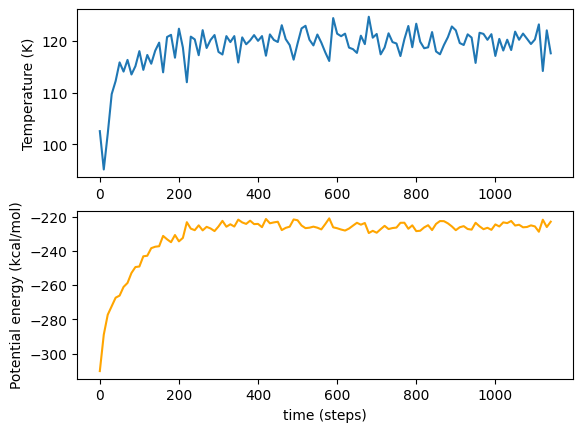

In [5]:
auto_temps = vals_dict['temp']
auto_potentials = vals_dict['pe']

plot_vars(auto_temps, auto_potentials)

And finally, we can see on the original equilibration graphs where the auto-equilibration
considered the graph to be stationary.

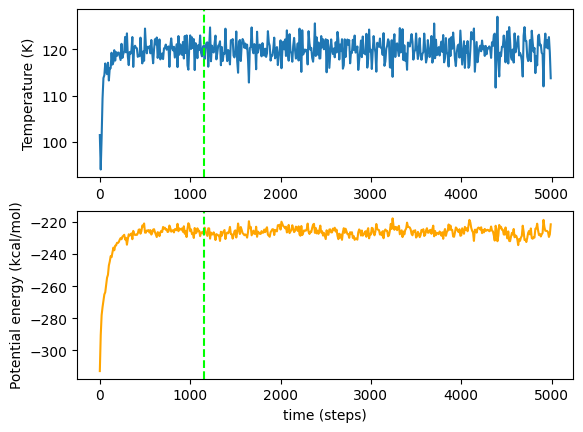

In [6]:
plot_vars(temperatures, potentials, line=total_steps)